## make semi supervised

In [2]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

In [10]:
Counter(dataset.obs.lineage)

Counter({'lung': 1359,
         'soft_tissue': 575,
         'skin': 630,
         'bile_duct': 82,
         'bladder': 473,
         'colon': 520,
         'lymphocyte': 188,
         'uterus': 278,
         'gastric': 469,
         'kidney': 1099,
         'pancreas': 299,
         'central_nervous_system': 1369,
         'fibroblast_bone': 9,
         'breast': 1323,
         'bone': 351,
         'upper_aerodigestive': 588,
         'ovary': 517,
         'cervix': 325,
         'blood': 1314,
         'esophagus': 283,
         'liver': 433,
         'peripheral_nervous_system': 245,
         'eye': 93,
         'fibroblast_skin': 7,
         'thyroid': 672,
         'plasma_cell': 29,
         'fibroblast_upper_aerodigestive': 1,
         'fibroblast_lung': 6,
         'embryo': 6,
         'fibroblast_breast': 6,
         'prostate': 663,
         'fibroblast_lymphocyte': 3,
         'fibroblast_colorectal': 3,
         'U': 207,
         'fibroblast_soft_tissue': 3,
         'a

In [11]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg38', 'hg19'}
method {'bulk'}
sequencer {'Illumina HiSeq 4000', 'Illlumina TruSeq', 'Illumina HiSeq 2000'}


In [5]:
loc = np.argsort(np.nanvar(dataset.X,0))[-3000:]
dataset = AnnData(dataset.X[:,loc], dataset.obs, dataset.var.iloc[loc])

In [374]:
# removing ultra rare samples
loc = dataset.obs["disease_type"].isin([
'Teratoma',
'Thymic Cancer',
'Nasopharyngeal Cancer',
'U',
'Endocrine Cancer',
'Pineal Cancer',
'Embryonal Cancer',
"Gallbladder Cancer"]) | dataset.obs["tissue_type"].isin([
'engineered_central_nervous_system',
'embryo',
'engineered_kidney',
'engineered_ovary',
'engineered',
'engineered_prostate',
'engineered_lung',
'adrenal_cortex',
'engineered_blood',
'engineered_breast',
'colon',
'nasopharynx',
'teratoma',
'endocrine',
'pineal'])

dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

In [12]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [6]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [66]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [68]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

In [74]:
dataset.obs.loc[(dataset.obs['passage_number']=="U") & (dataset.obs['dataset']=="tcga"), 'passage_number'] = "none"

In [76]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & (dataset.obs['dataset']=="tcga"), 'cell_format'] = "none"

In [77]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & (dataset.obs['dataset']=="met500"), 'cell_format'] = "none"

In [79]:
dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset

sample_id
CCLF_PEDS1034-Tumor-SM-HUQMD    cclf
CCLF_PEDS1083-Tumor-SM-HUQNX    cclf
CCLF_RCRF1009-Tumor-SM-GBIV9    cclf
CCLF_RCRF1015-Tumor-SM-HPY1P    cclf
CCLF_RCRF1019-Tumor-SM-HUQM5    cclf
CCLF_RCRF1020-Tumor-SM-HUQM7    cclf
HCM-CSHL-0434-C24-01A           hcmi
HCM-CSHL-0434-C24-06A           hcmi
HCM-CSHL-0434-C24-85M           hcmi
HCM-CSHL-0434-C24-85A           hcmi
Name: dataset, dtype: category
Categories (6, object): ['ccle', 'cclf', 'hcmi', 'met500', 'pediatric_PDX', 'tcga']

In [50]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset,
    condition_keys=['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format'],
    predictor_keys=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt' , 'cell_type', 'morphology', 'ethnicity', 'instability', 'hasebv', 'contamination', 'base_media', 'stage','passage_number',],
    hidden_layer_sizes=[526, 256, 128],
    classifier_hidden_layer_sizes=[32, 64, 128],
    use_mmd = False,
    latent_dim=32,
    beta=500,
    betaclass=0.8,
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 526 86
	Hidden Layer 1 in/out: 526 256
	Hidden Layer 2 in/out: 256 128
	Mean/Var Layer in/out: 128 32
Classifier Architecture:
	First Layer in/out:  32 32
	Hidden Layer 1 in/out: 32 64
	Hidden Layer 2 in/out: 64 128
	Output Layer in/out:  128 364 

Decoder Architecture:
	First Layer in, out and cond:  32 128 86
	Hidden Layer 1 in/out: 128 256
	Hidden Layer 2 in/out: 256 526
	Output Layer in/out:  526 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: index -1 is out of bounds for dimension 1 with size 86

In [40]:
cl2.save('./temp/model', overwrite=True)

In [37]:
# doesn't work, the model then outputs nans as latent factors.
cl2 = celligner2.CELLIGNER2.load(dir_path='./temp/model', adata=dataset)

AnnData object with n_obs × n_vars = 15064 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'celligner2_size_factors'


TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [38]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

we have a certain distribution of passage numbers only based on CCLF samples. looking at CCLE we expect high passages considerign they are historical cell lines. this is what we get

In [207]:
Counter(obs[(obs['passage_number']!="U")]['passage_number'])

Counter({'verylow': 6, 'medium': 39, 'high': 31, 'low': 14})

In [206]:
#obs = evaluator_less.adata_latent.obs
Counter(obs[(obs['passage_number']=="U") & (obs.dataset=="ccle")]['passage_number_pred'])

Counter({'medium': 435, 'high': 952, 'low': 24})

then it doesn't make any sense on tcga (we would expect low if anything else)

In [208]:
Counter(obs[(obs['passage_number']=="U") & (obs.dataset=="tcga")]['passage_number_pred'])

Counter({'high': 8430, 'low': 2444, 'verylow': 807, 'medium': 555})

In [40]:
evaluator.get_class_quality(classes=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt', 'reference', 'cell_type', 'sequencer', 'sample_type', 'base_media', 'morphology', 'ethnicity', 'instability', 'hasebv', 'align', 'counter', 'passage_number', 'contamination', 'stage', 'conservation', 'cell_format'])

lineage
all predicted categories:  {'cervix', 'bone', 'esophagus', 'ampulla of vater', 'liver', 'testis', 'germ_cell', 'gastric', 'colon', 'breast', 'gall_bladder', 'plasma_cell', 'thyroid', 'fibroblast_bone', 'upper_aerodigestive', 'lymphocyte', 'soft_tissue', 'ovary', 'eye', 'prostate', 'peripheral_nervous_system', 'kidney', 'bile_duct', 'pancreas', 'central_nervous_system', 'oral', 'brain', 'blood', 'embryo', 'stomach', 'lung', 'intrahepatic bile duct', 'uterus', 'skin', 'fibroblast_skin', 'extrahepatic bile duct', 'adrenal', 'bladder'}
accuracy:  0.968432388772969
F1 Score: 0.67


collection_site
all predicted categories:  {'large_intestine', 'cerebellum', 'cervix', 'leg', 'bone', 'esophagus', 'haematopoietic_and_lymphoid_tissue', 'endometrium', 'sigmoid_colon', 'pleura', 'peripheral_blood', 'retroperitoneal', 'transverse_colon', 'liver', 'peritoneal', 'appendix', 'biliatract', 'rectosigmoid_junction', 'colon', 'heart', 'paracaval_lymph_node', 'breast', 'peritoneum', 'sylvian_fissu

In [149]:
evaluator_less.adata_latent.obs.lineage_pred = evaluator_less.adata_latent.obs.lineage_pred.str.split("_").str[-1]

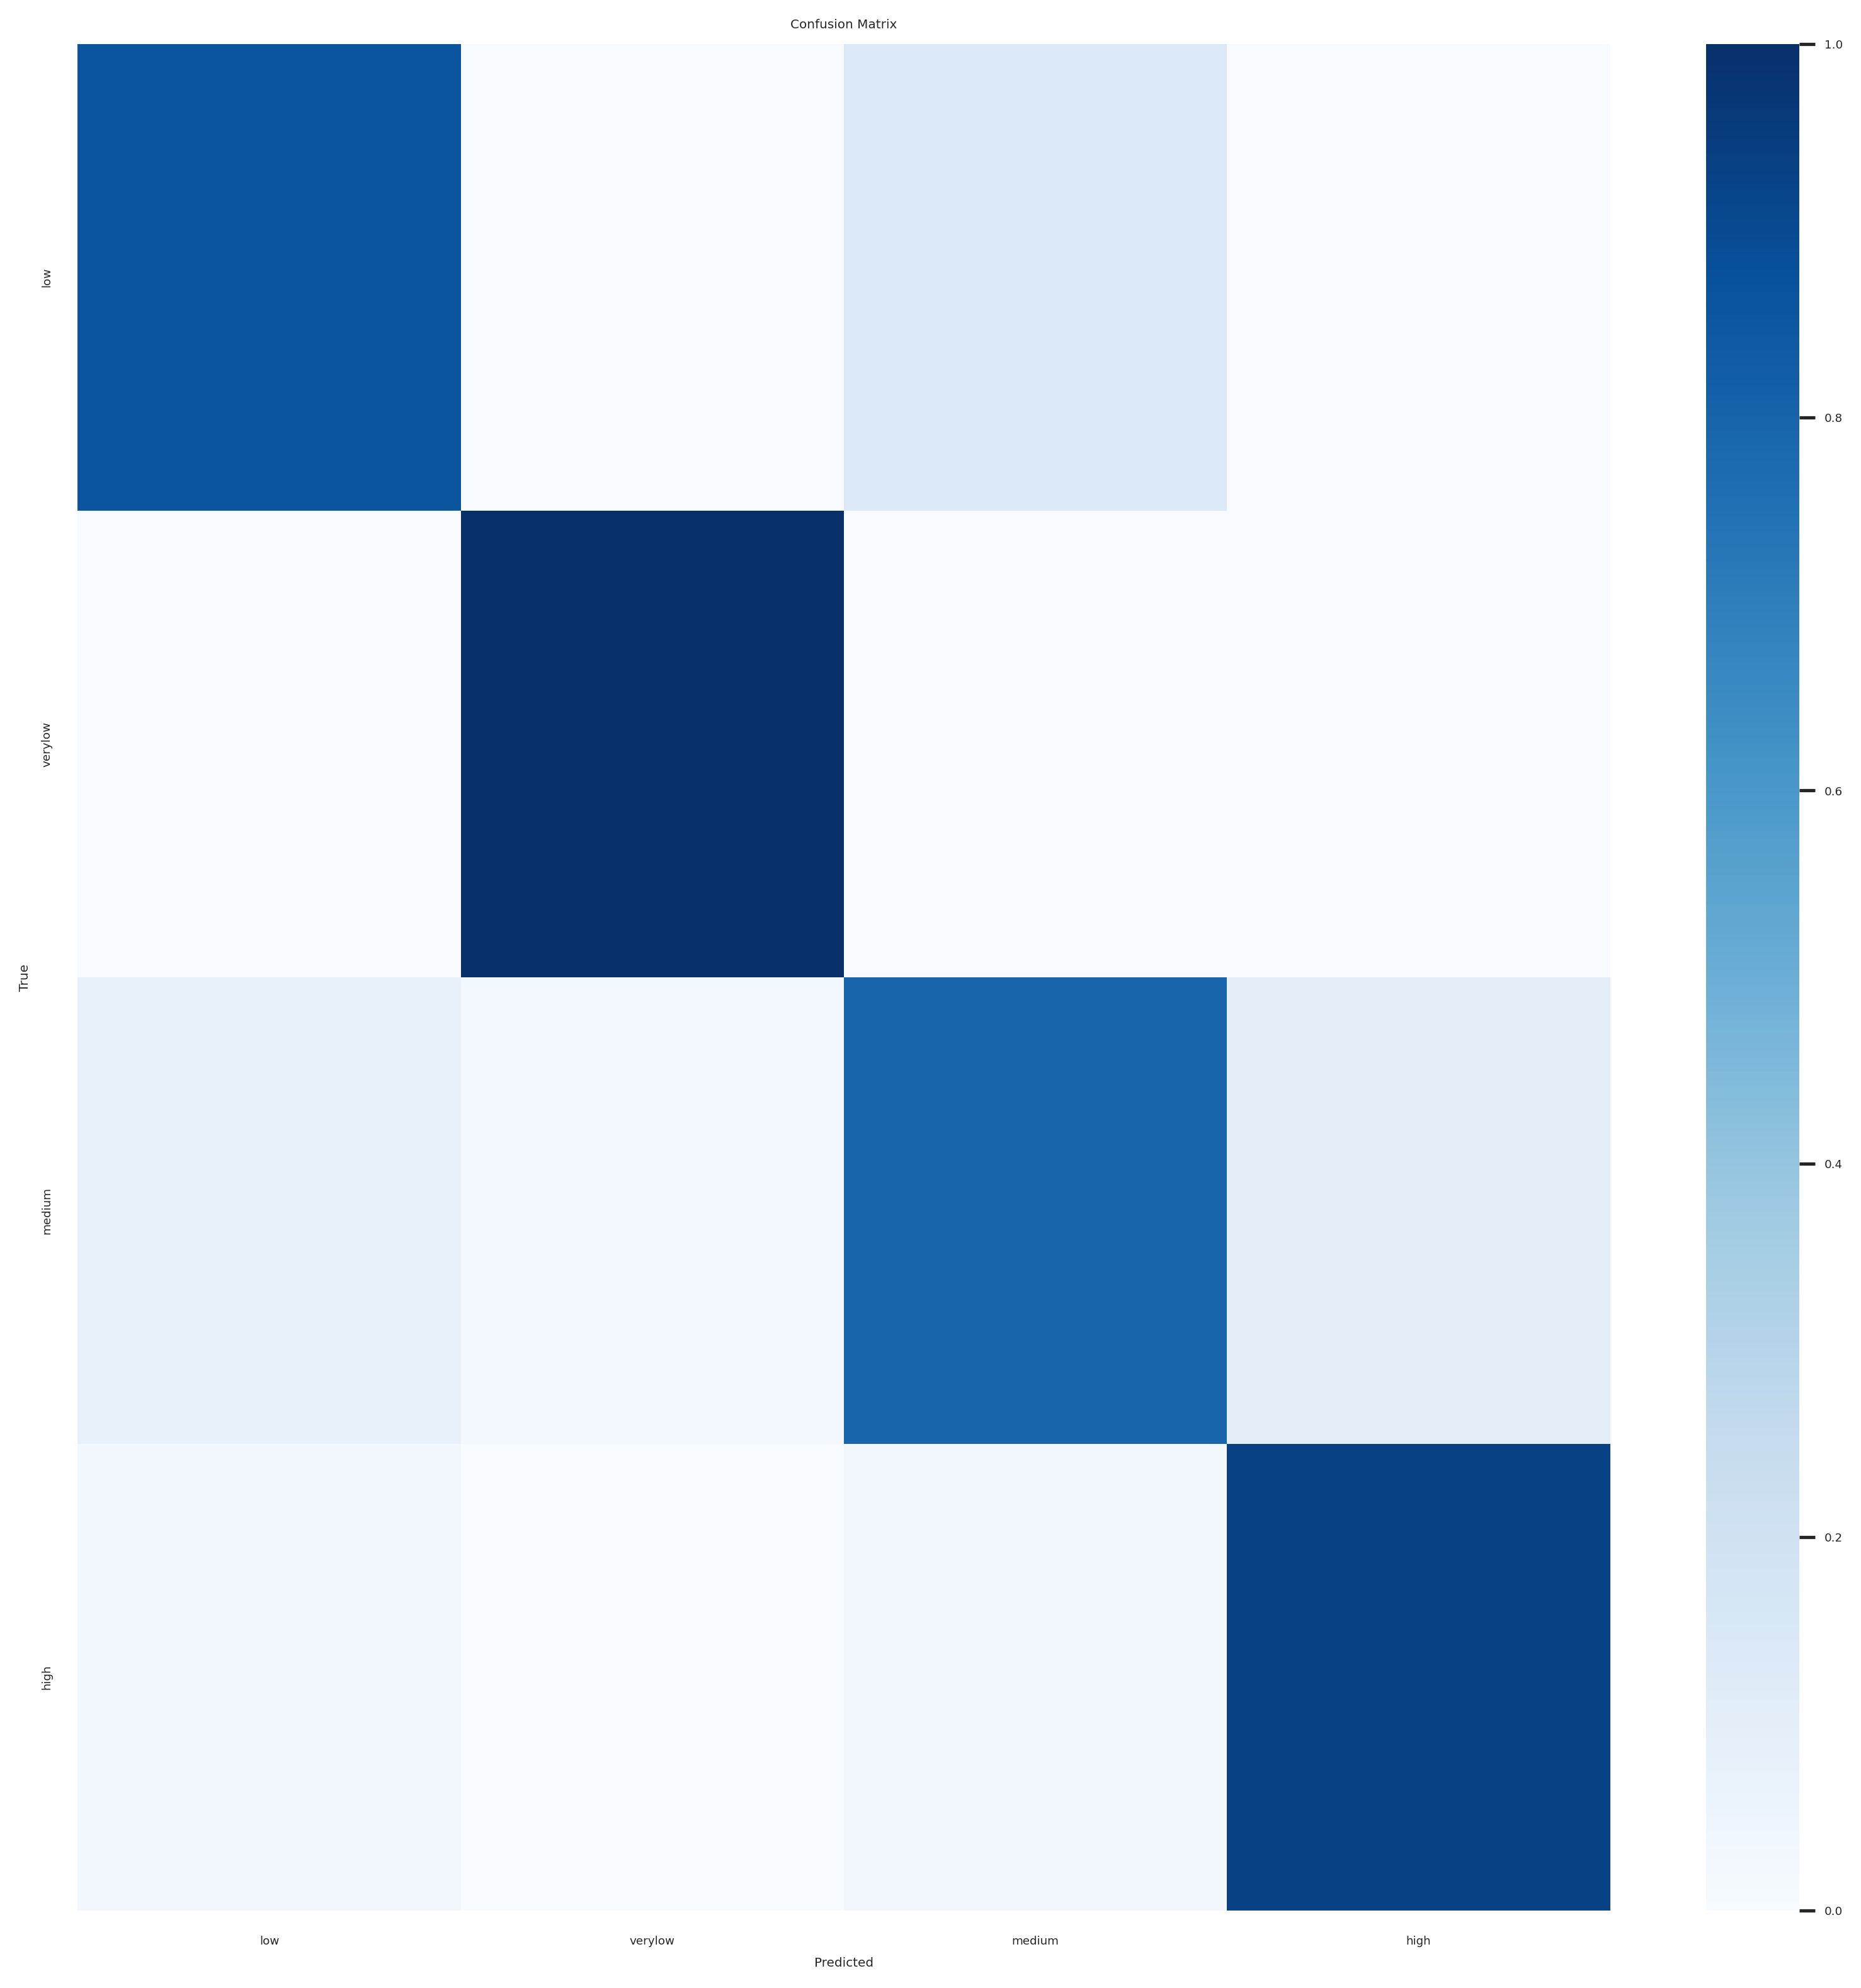

In [175]:
conf = evaluator_less.getconfusionMatrix(on="passage_number", only=None)

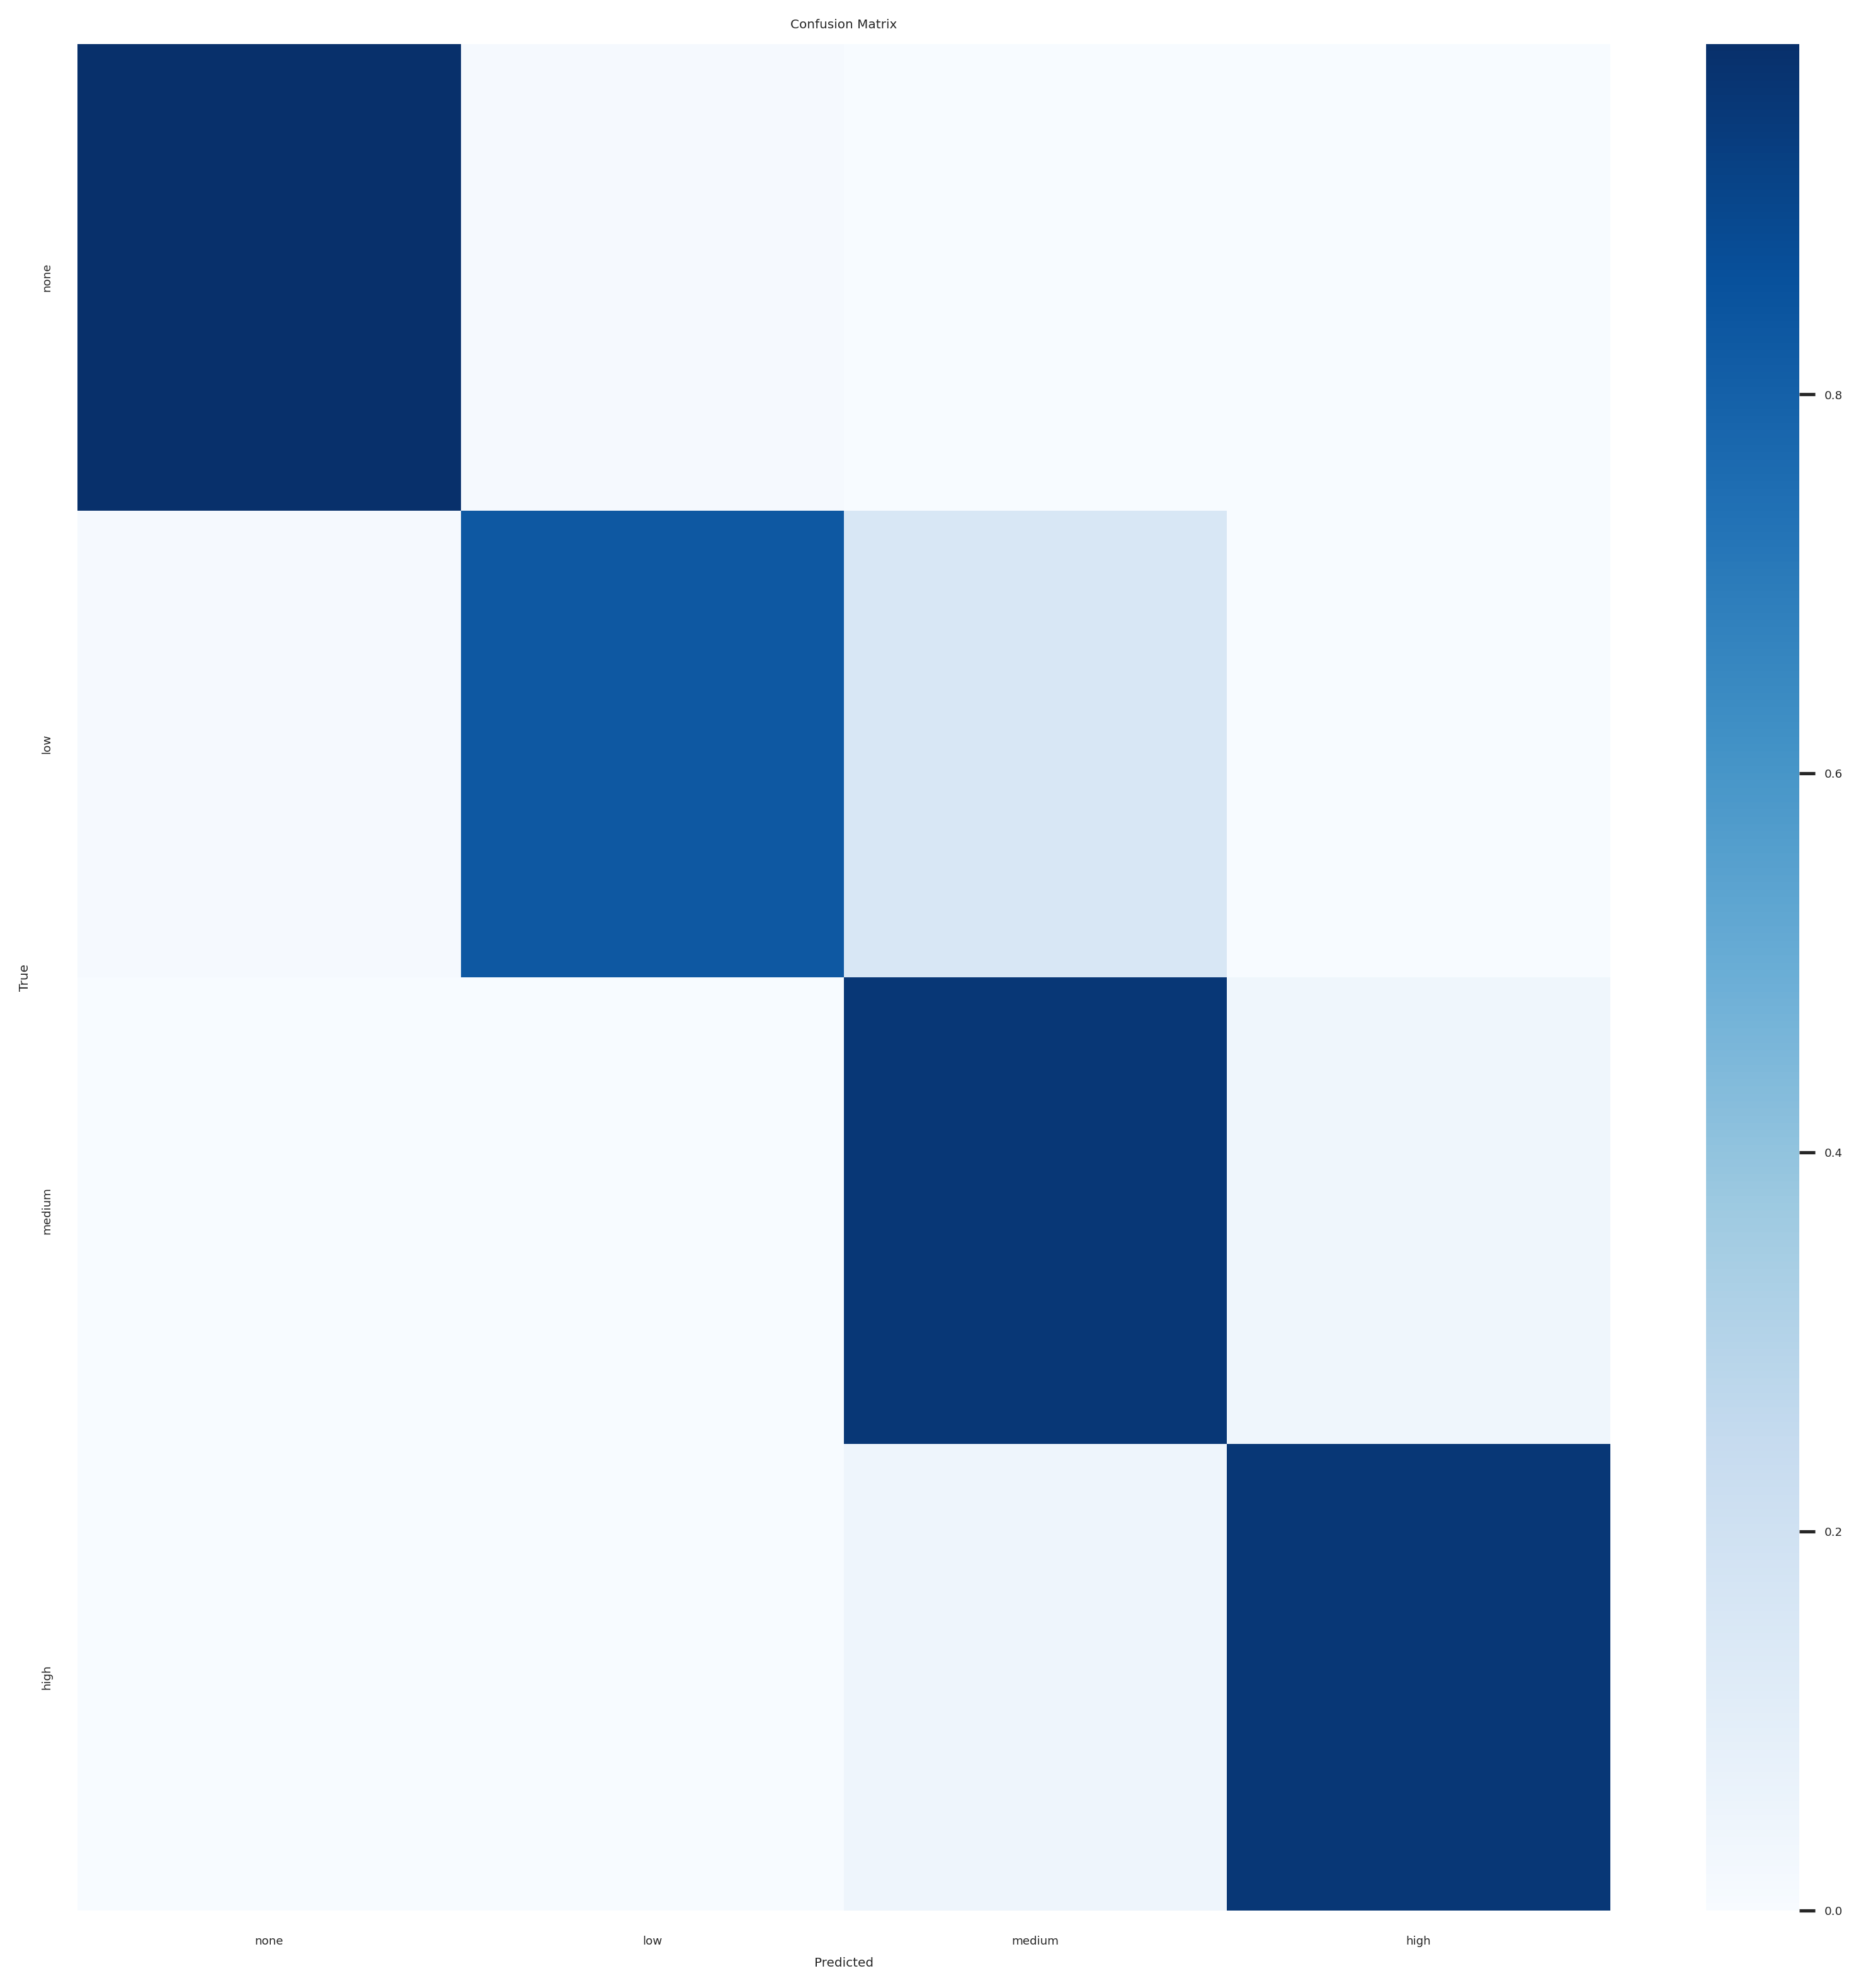

In [176]:
conf = evaluator_less.getconfusionMatrix(on="contamination", only=None)

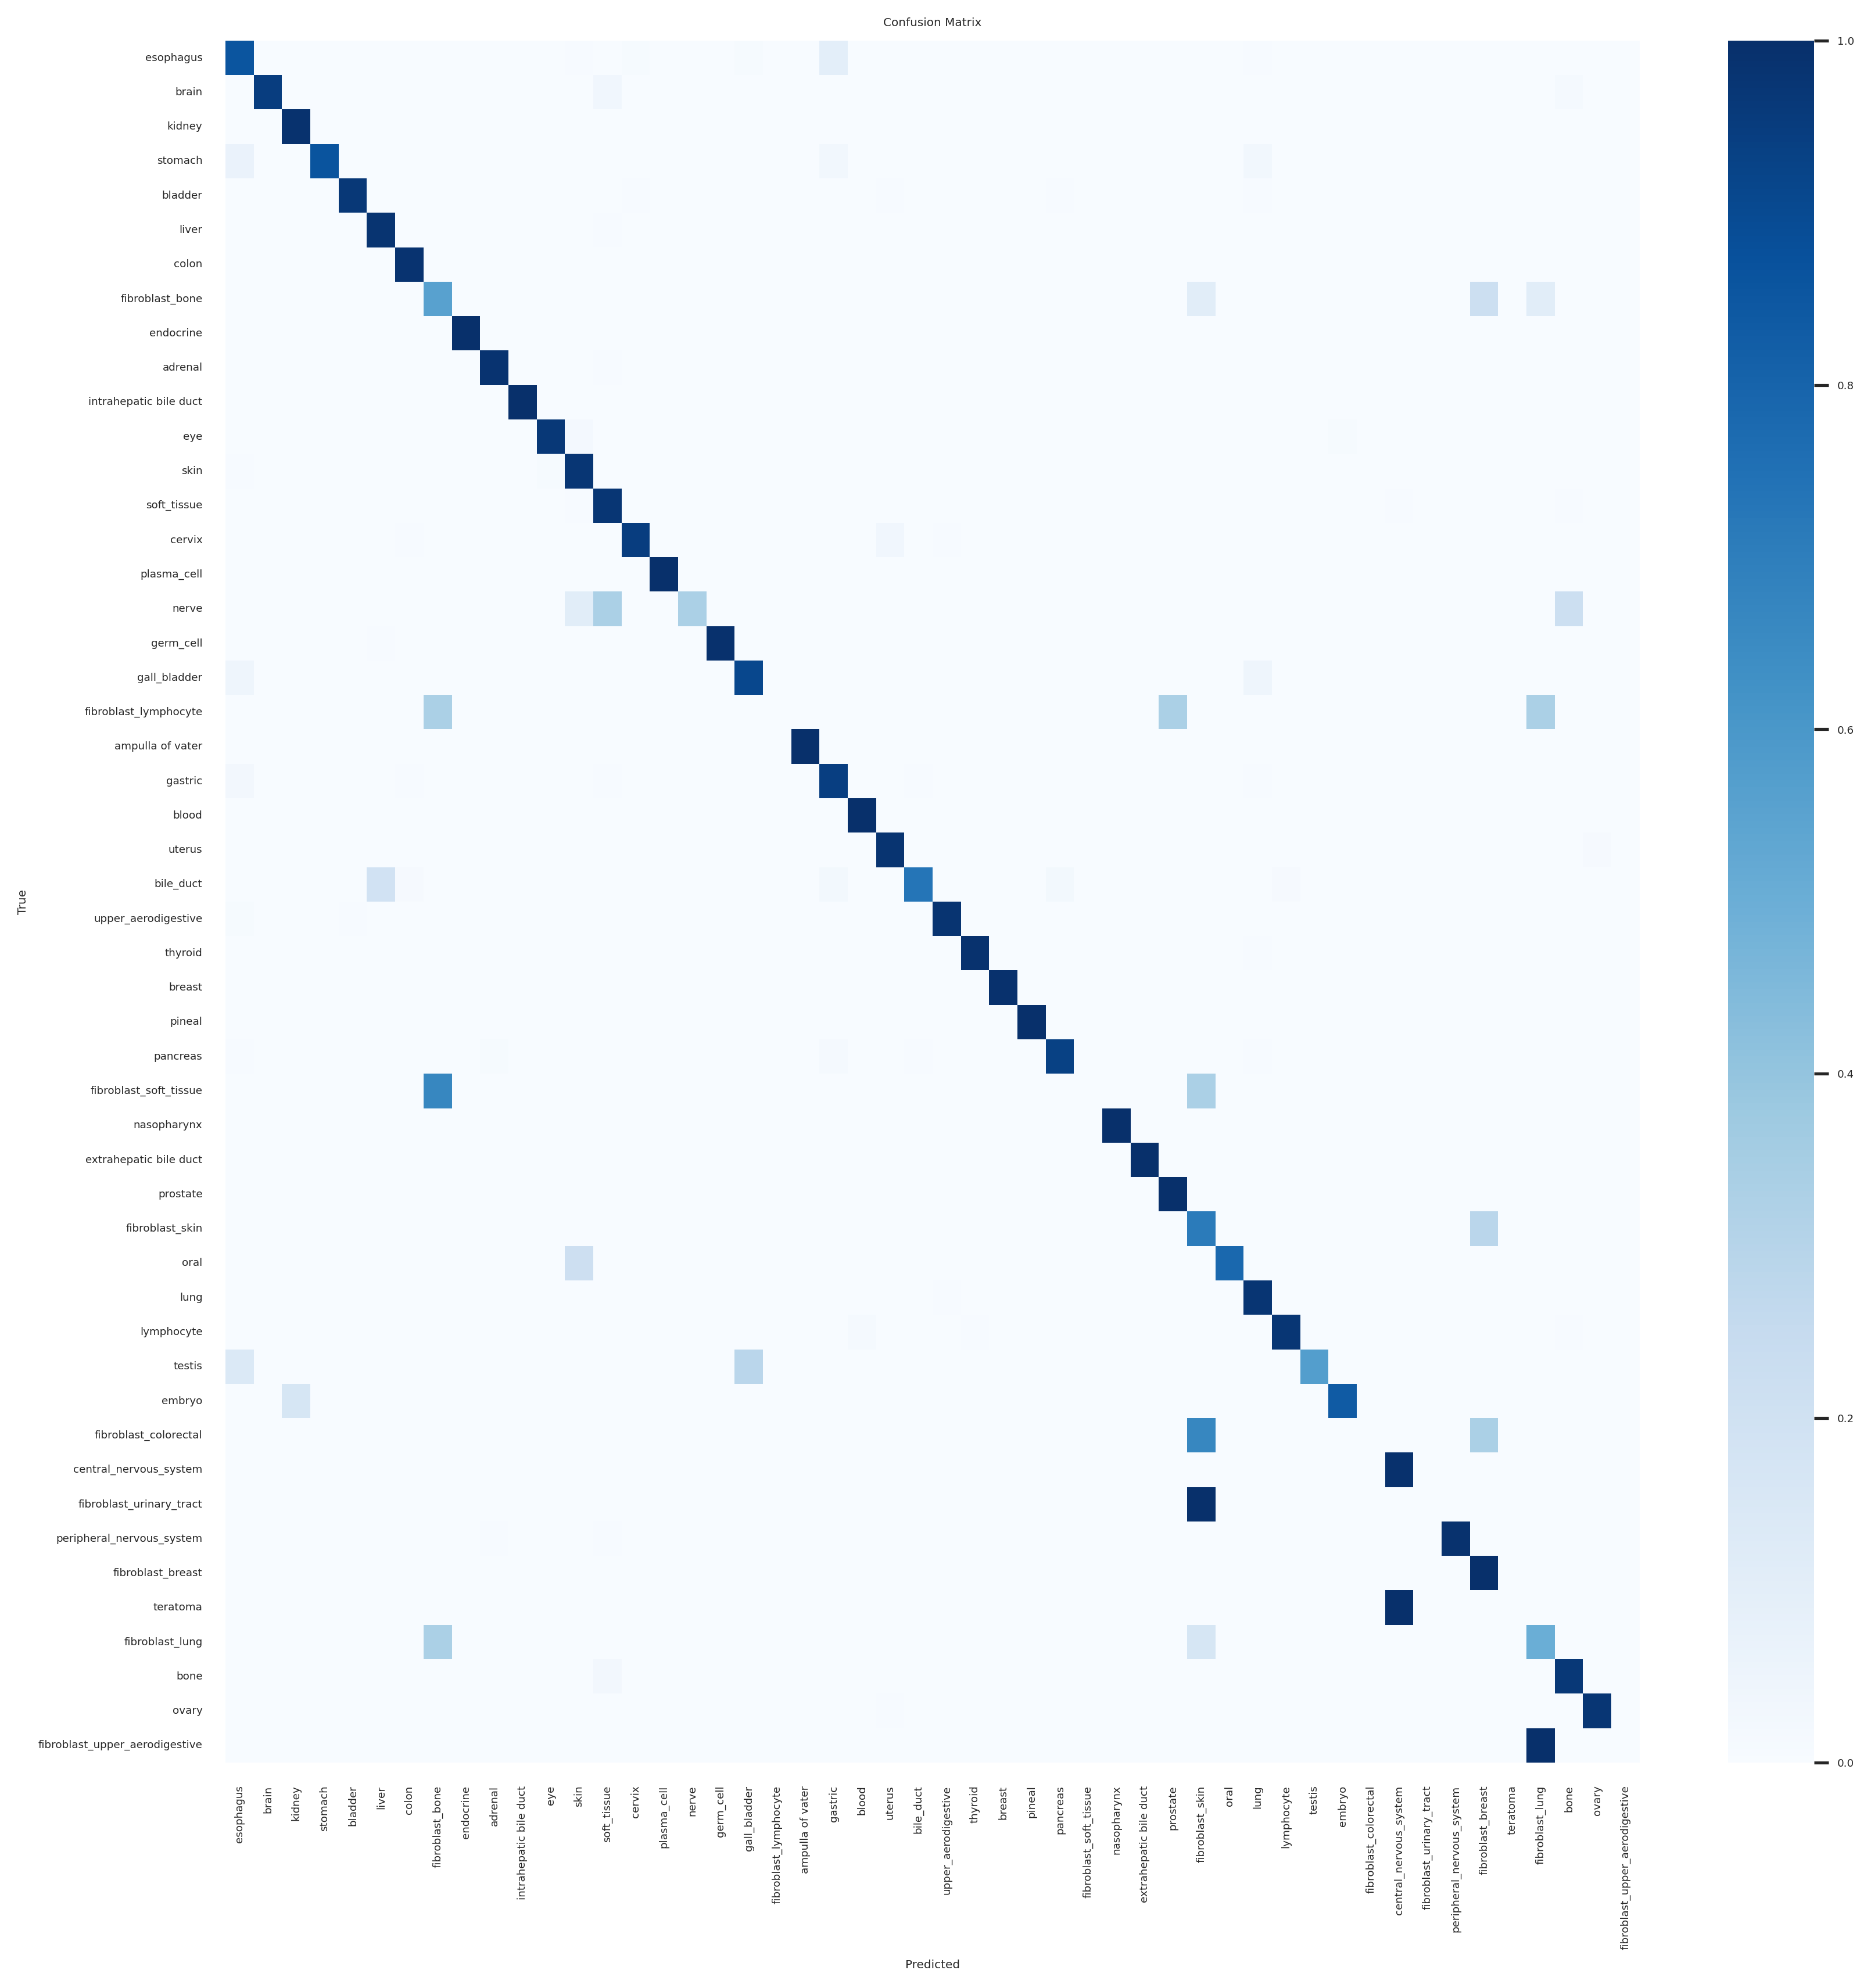

In [211]:
conf = evaluator_less.getconfusionMatrix(on="lineage", only=None)

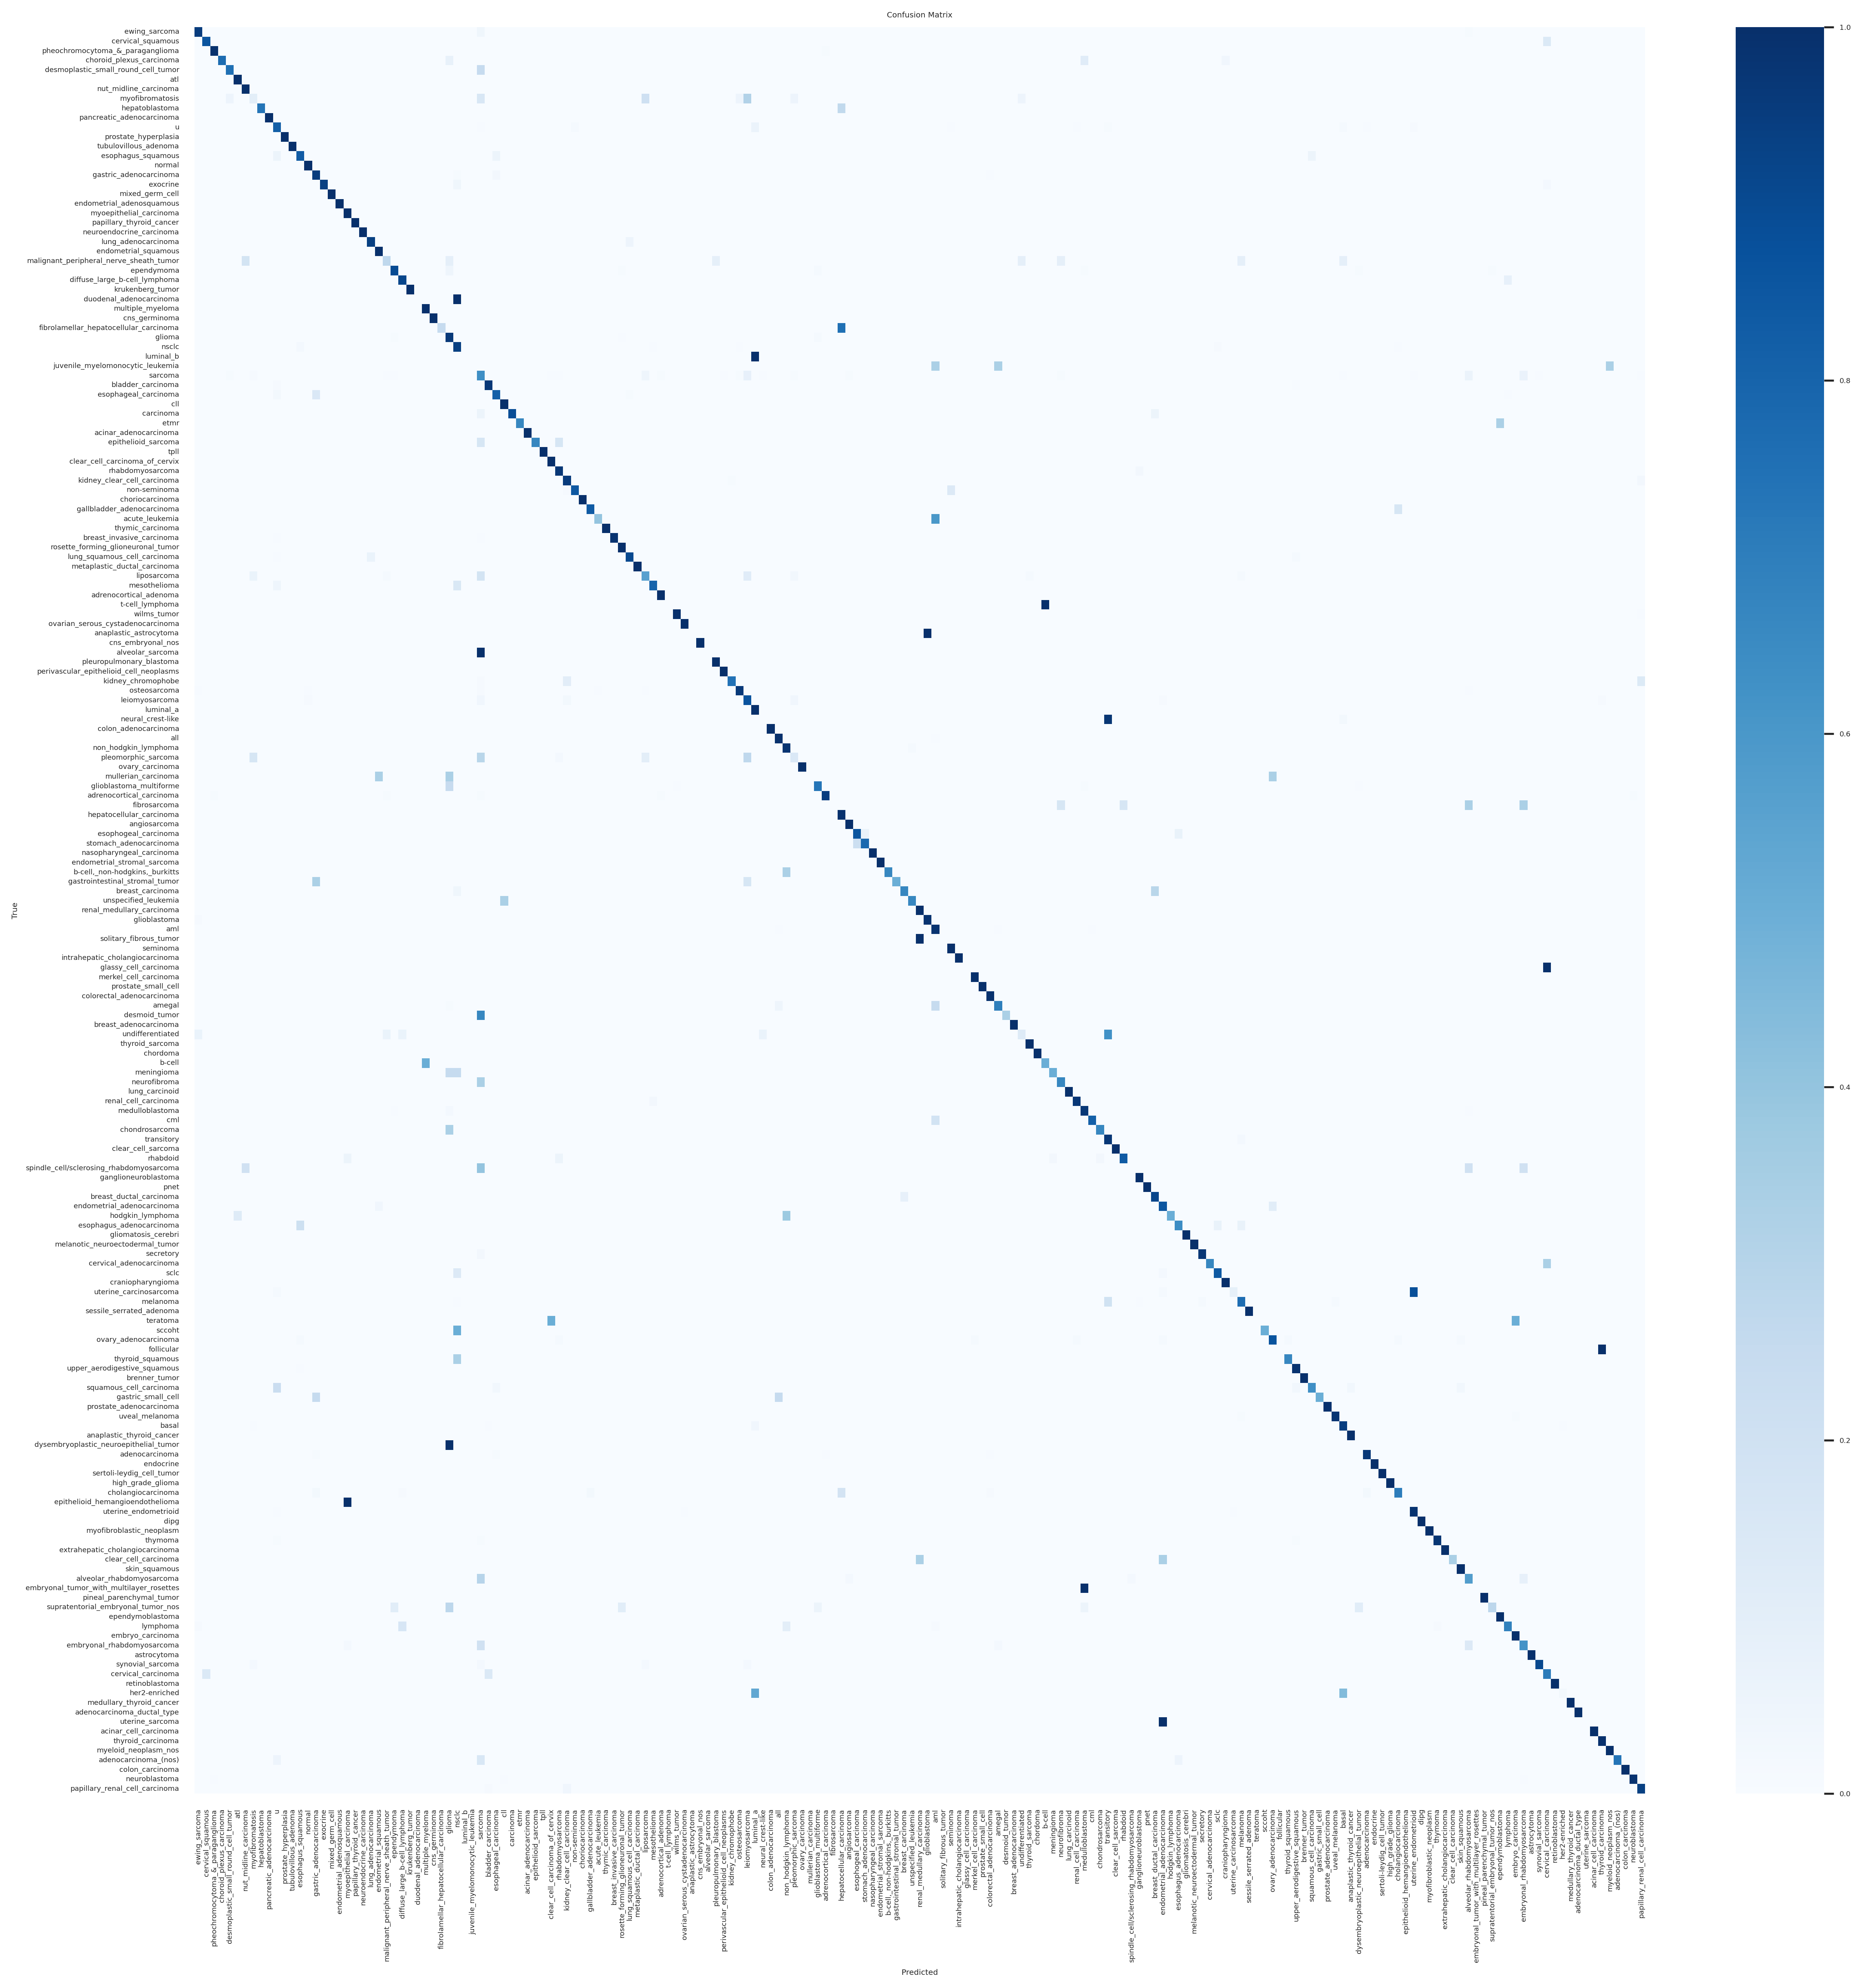

In [212]:
conf = evaluator_less.getconfusionMatrix(on="disease_type", only=None, figsize=(20,20), font_scale=3)

In [1]:
import pynndescent

KeyboardInterrupt: 

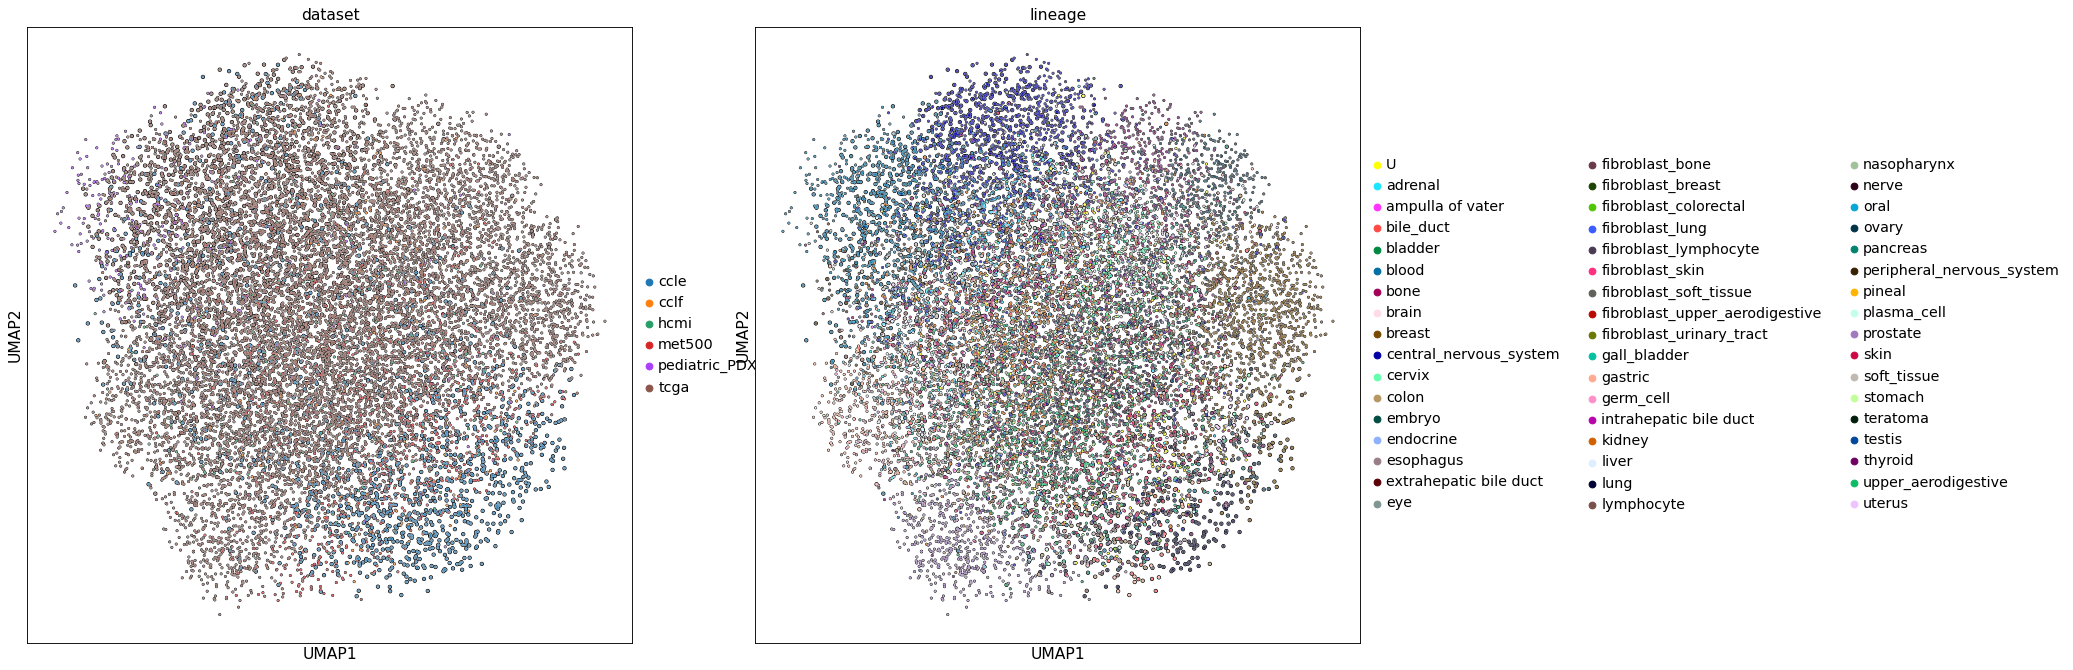

In [47]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=3,
                            random_state=None),
        color=['dataset', 'lineage'],
        projection="2d",
        n_neighbors=14,
        add_outline=True,
        size=[20]*len(dataset[dataset.obs['dataset']!='tcga']) + [10]*len(dataset[dataset.obs['dataset']=='tcga']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


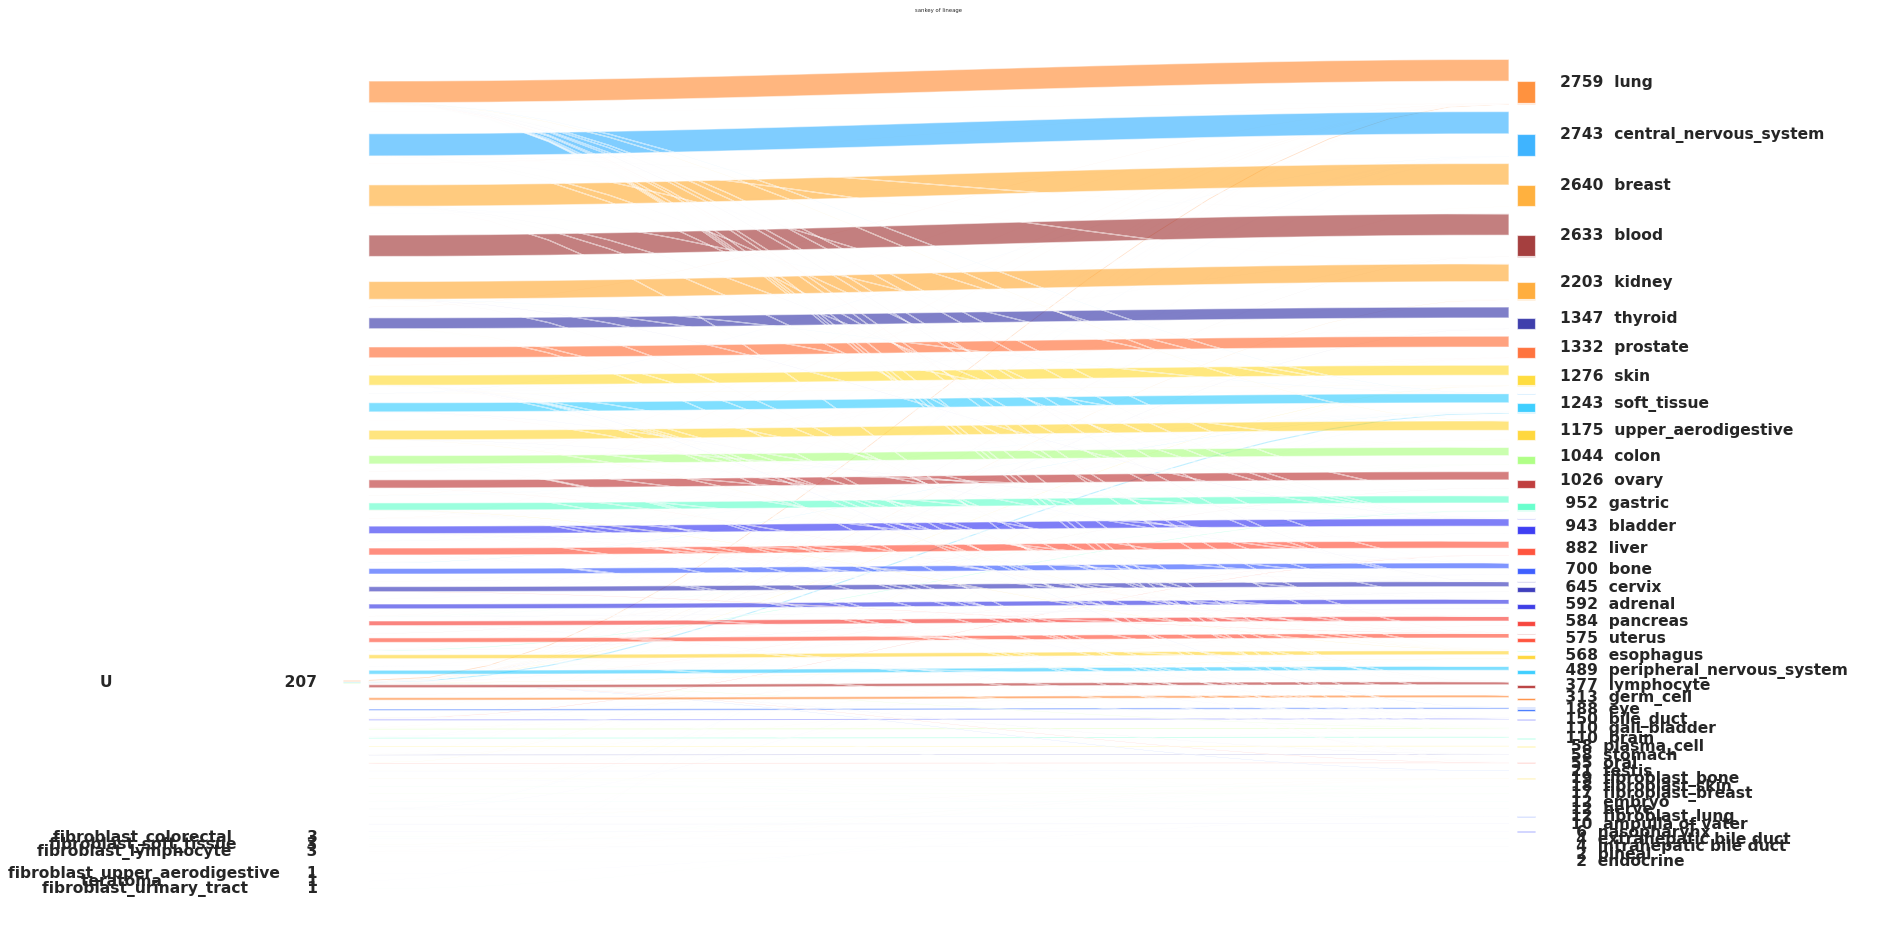

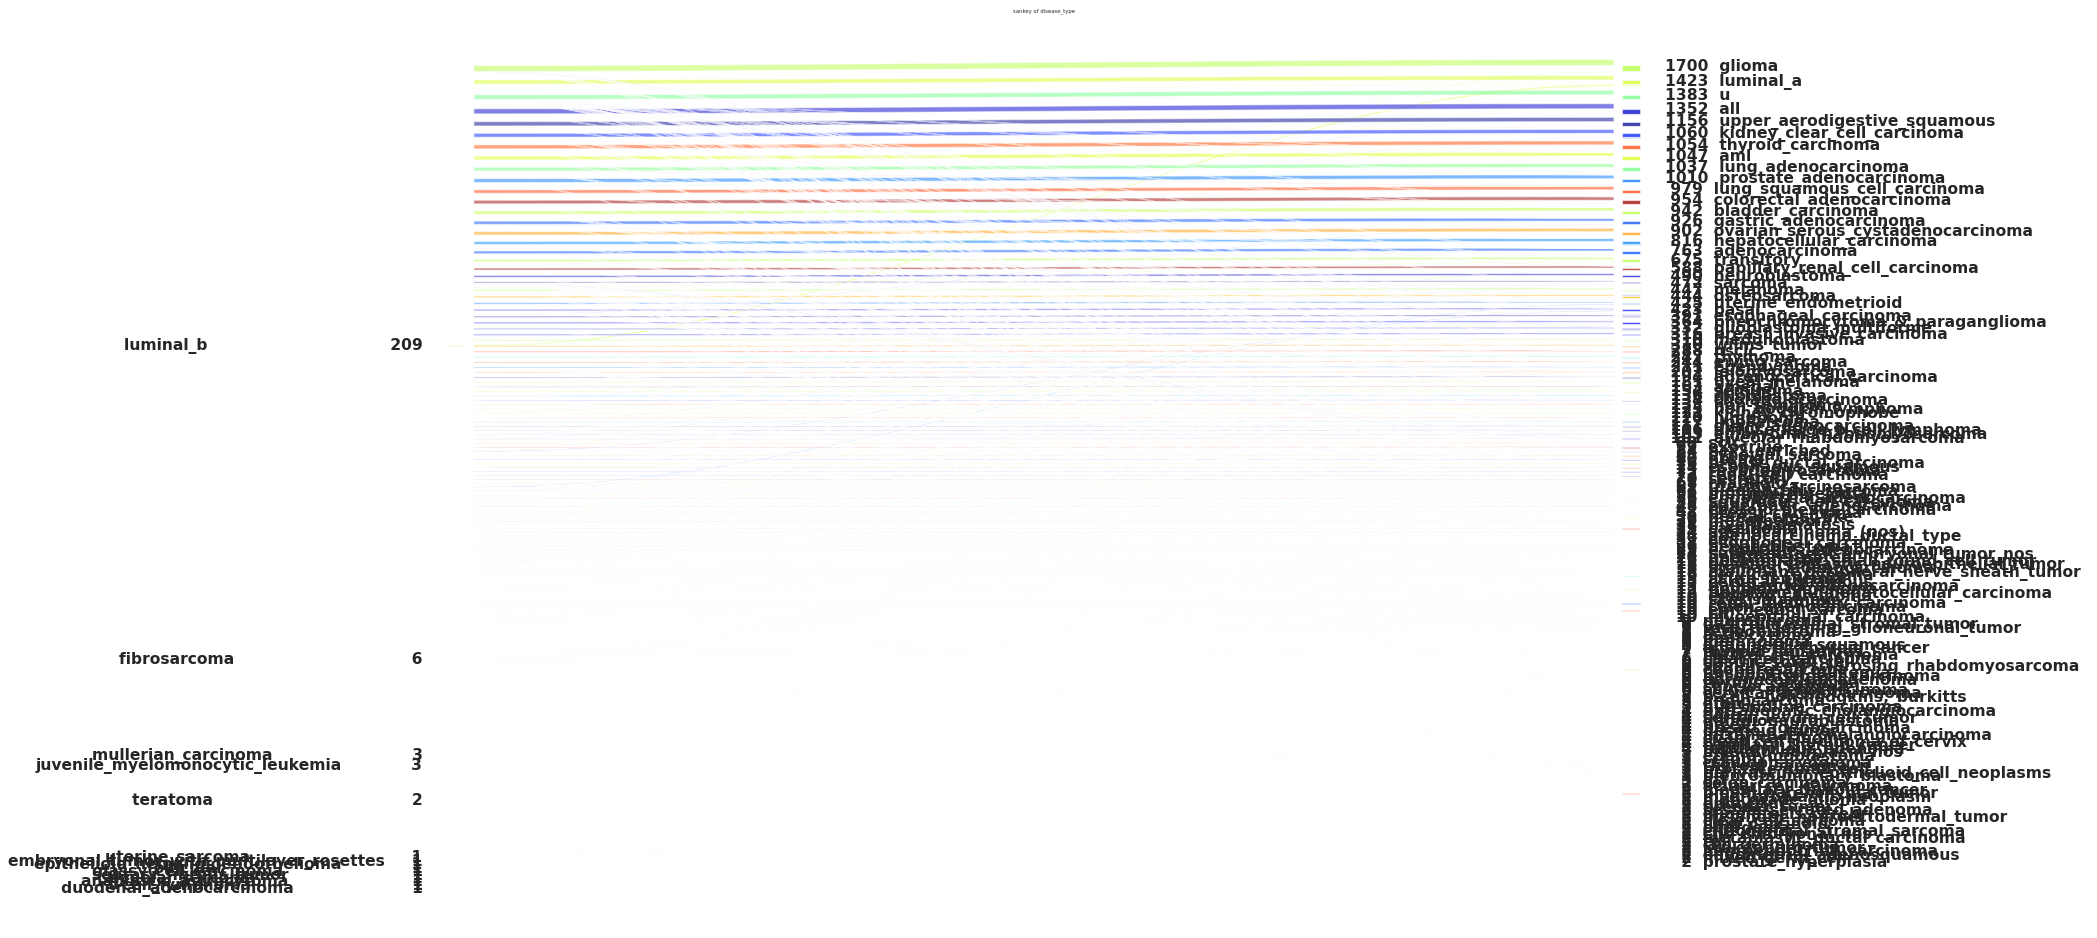

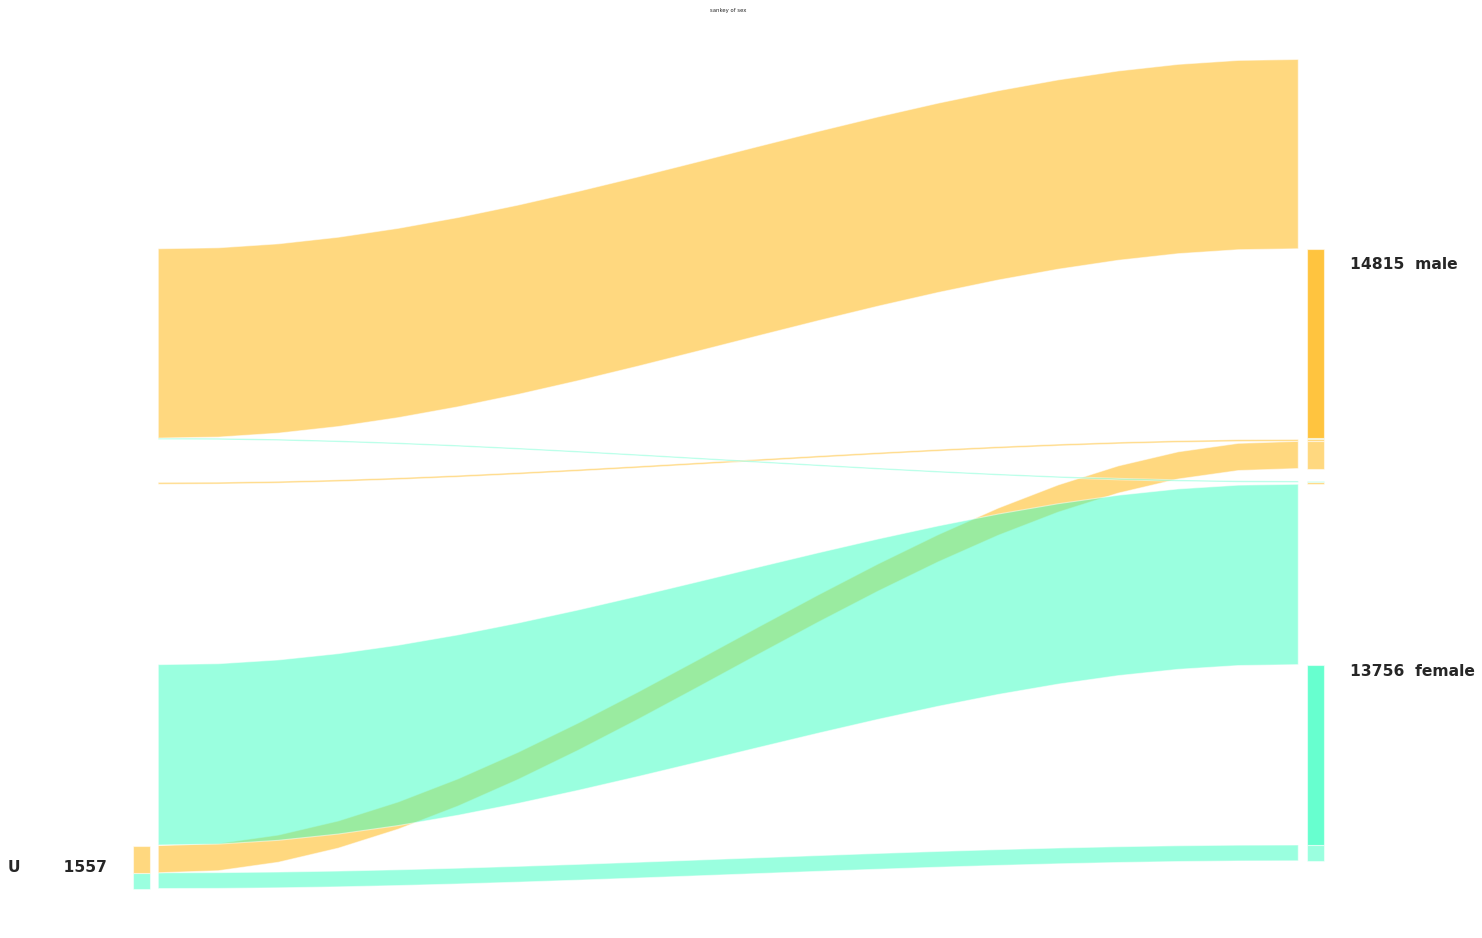

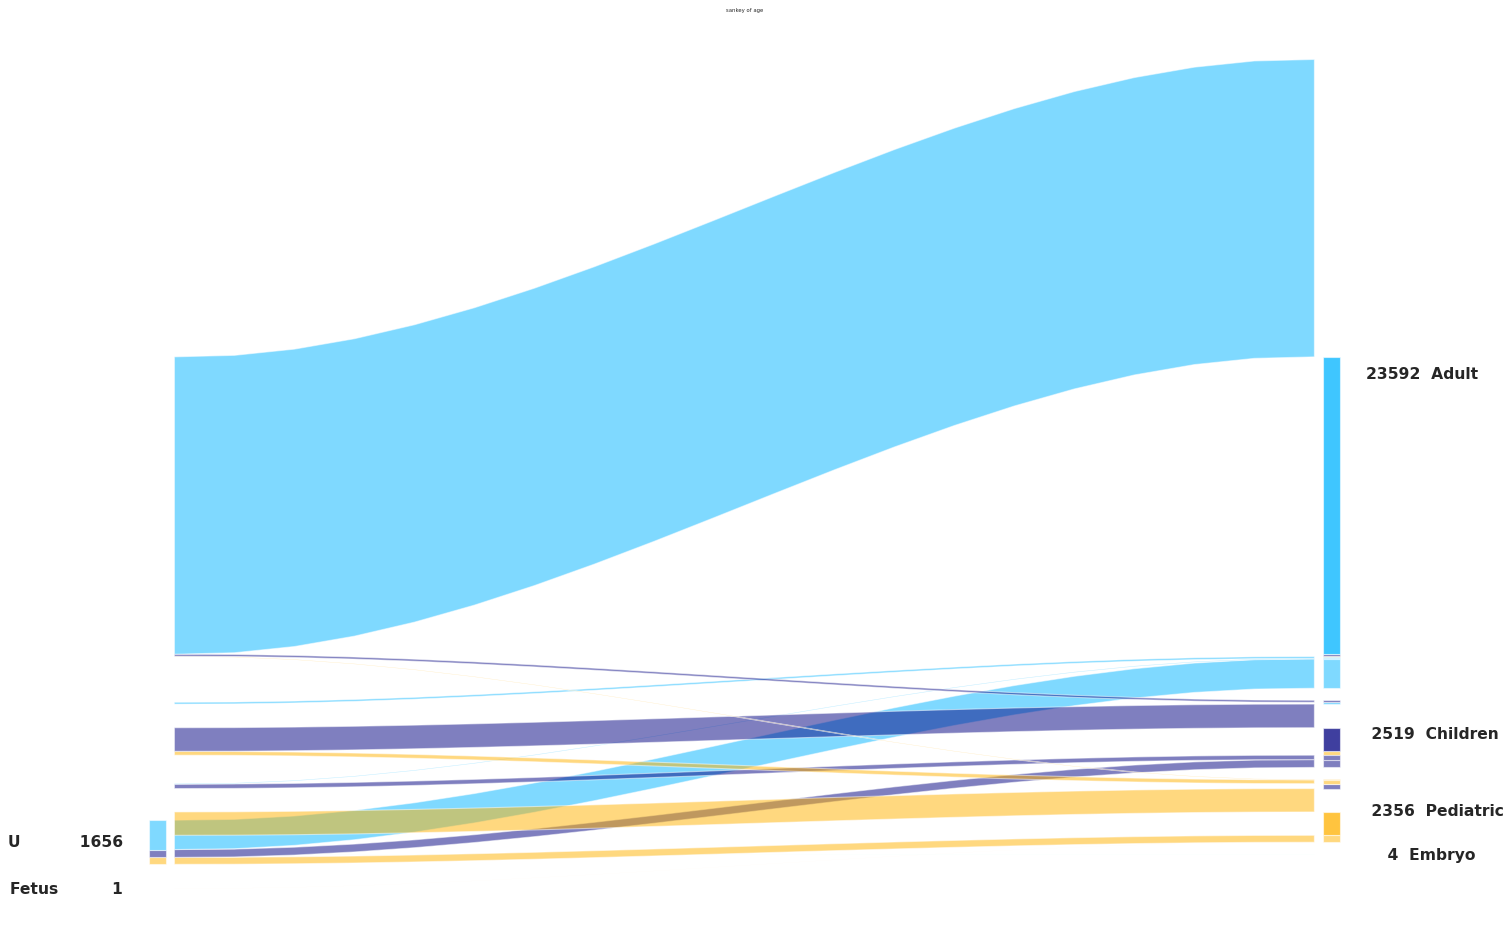

In [218]:
evaluator_less.plot_classification(classes=['lineage', 'disease_type', 'sex', 'age'])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


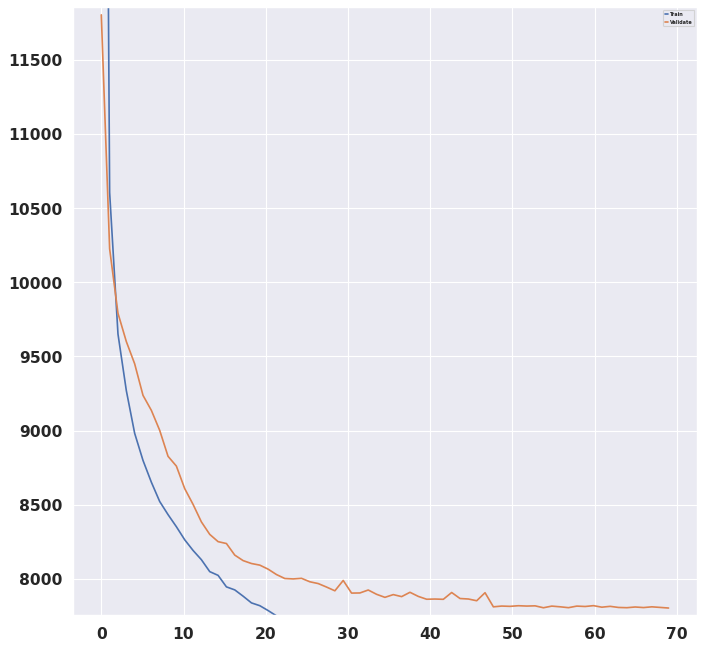

<Figure size 800x800 with 0 Axes>

In [219]:
evaluator_less.plot_history()

In [225]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.8997235557965478
ASW on celltypes: 0.4701786618679762
Calculating EBM with n_cat = 51
Latent-Space Score EBM+KNN, EBM, KNN: 0.64, 0.45, 0.19


KeyboardInterrupt: 

In [21]:
## what would it look like as tumor
#print(cl2_less.adata.obs.iloc[:100])
size = 20
reco_tumor = cl2.reconstruct(evaluator.adata_latent[:size].X, pd.DataFrame(data=['tcga']*size, columns=['dataset']))
reco = cl2.reconstruct(evaluator.adata_latent[:size].X, pd.DataFrame(data=['ccle']*size, columns=['dataset']))
true = cl2.adata[:size].X

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
cl2.adata['ACH-000638']

View of AnnData object with n_obs × n_vars = 1 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'celligner2_size_factors'

In [24]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.iloc[:size], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.iloc[:size], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.iloc[:size], dataset.var)

In [25]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index]
coeff = pd.DataFrame(data=np.corrcoef(true.X, reco.X), columns = name, index = name)

<AxesSubplot:>

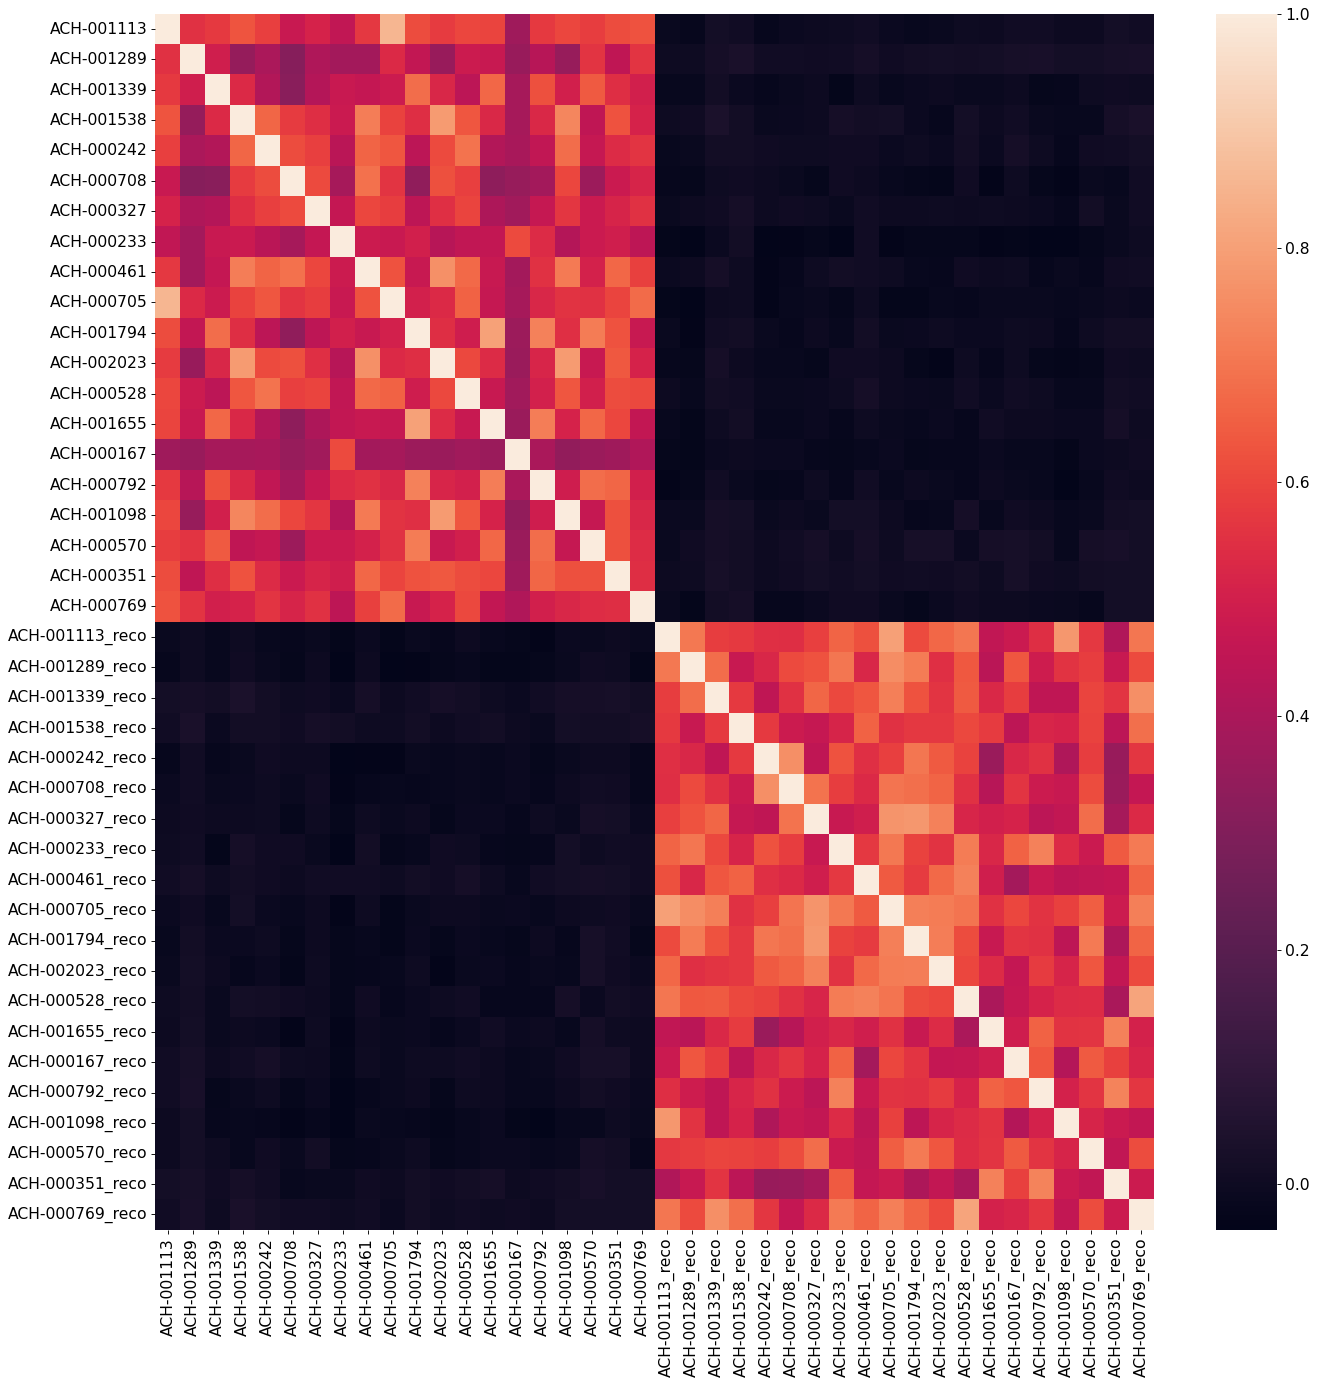

In [26]:
import seaborn as sns 
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

In [28]:
sa = cl2.adata.obs
clloc = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].index[:size]
tmloc = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].index[:size]

In [29]:
reco_tumor = cl2.reconstruct(evaluator.adata_latent[clloc].X, pd.DataFrame(data=['tcga']*size, columns=['dataset']))
reco = cl2.reconstruct(evaluator.adata_latent[clloc].X, pd.DataFrame(data=['ccle']*size, columns=['dataset']))
true = cl2.adata[clloc].X
tumor_eq = cl2.adata[tmloc].X

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [30]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.loc[clloc], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.loc[clloc], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.loc[clloc], dataset.var)
tumor_eq.columns = dataset.var.index
tumor_eq = AnnData(tumor_eq, cl2.adata.obs.loc[tmloc], dataset.var)

In [31]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index] + [i+"_reco_tumor" for i in reco.obs.index] + tumor_eq.obs.index.tolist()
coeff = pd.DataFrame(data=np.corrcoef(np.vstack([true.X,reco.X,reco_tumor.X, tumor_eq.X])), columns = name, index = name)

In [32]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],true.obs.index.tolist()].mean().mean()

-0.009438997014656003

In [33]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],tumor_eq.obs.index.tolist()].mean().mean()

-0.01856164508306337

In [34]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],[i+"_reco" for i in reco.obs.index]].mean().mean()

0.6019774873240127

<AxesSubplot:>

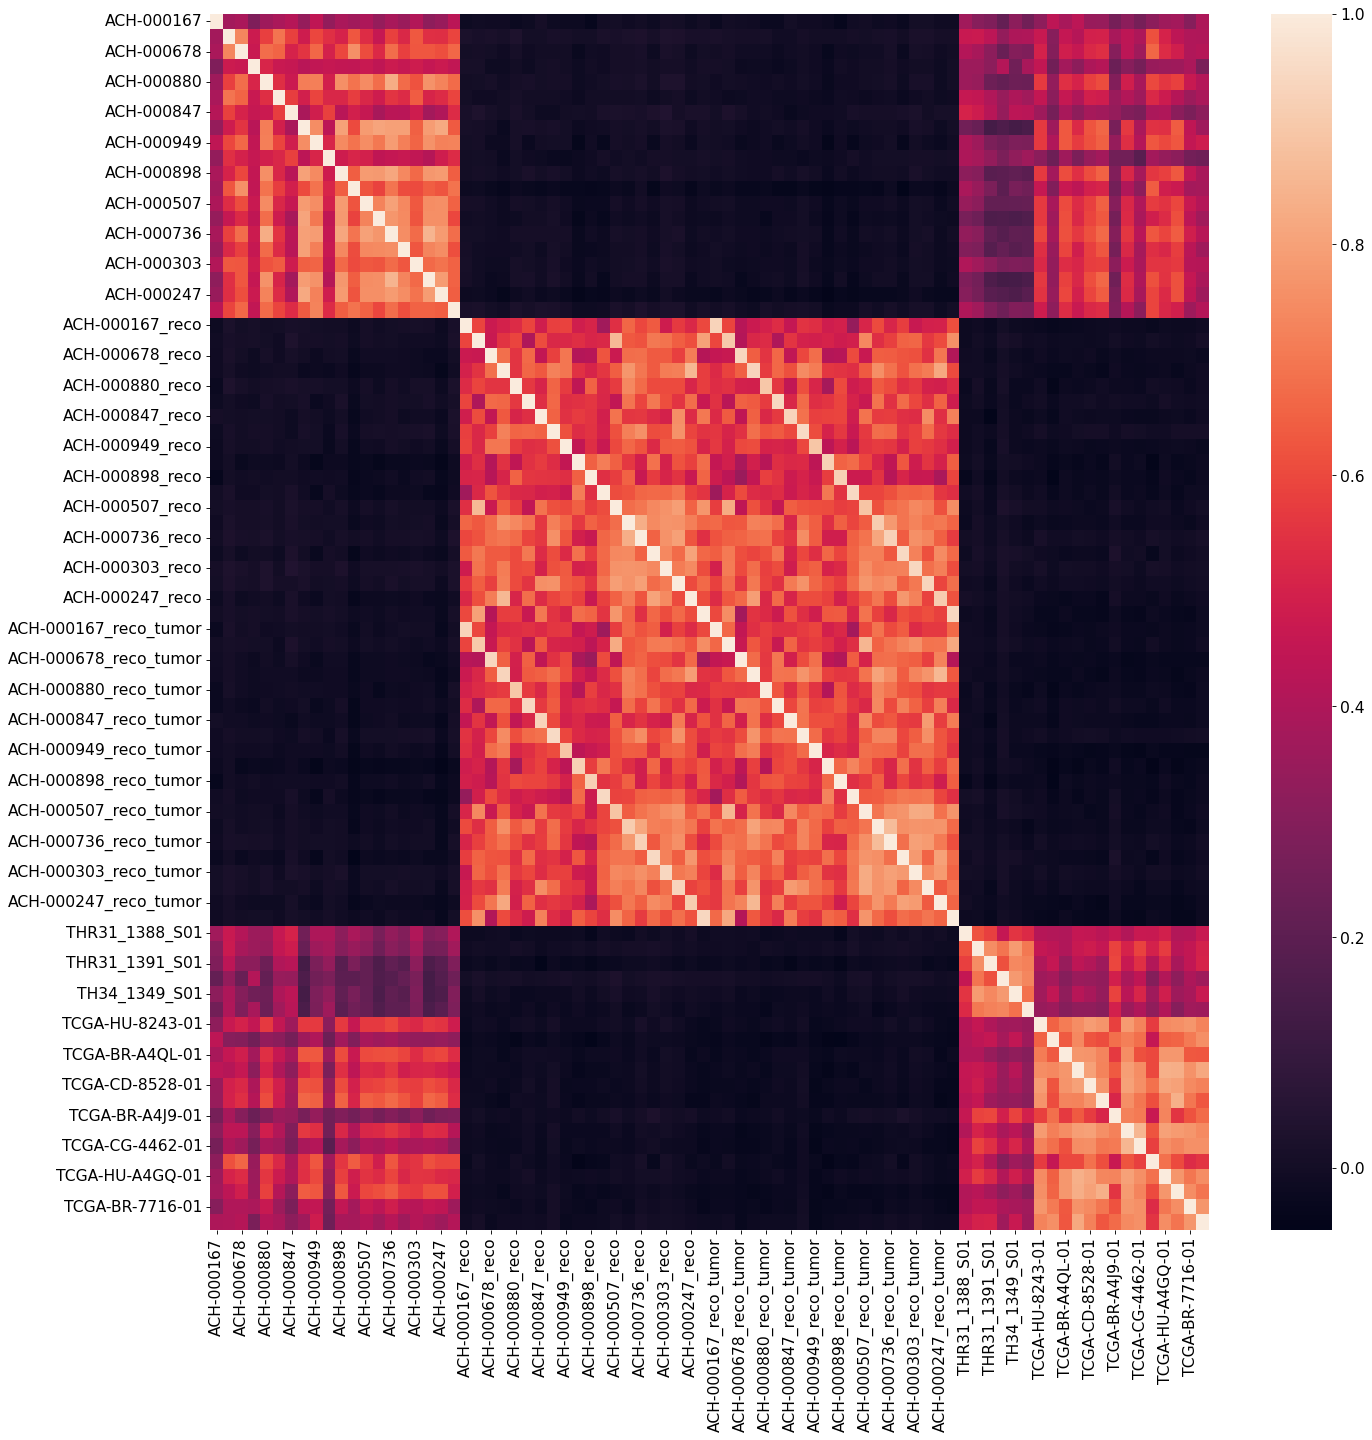

In [35]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

39,000,000 input 

811,852 parameter

## zenodo

In [ ]:
ACCESS_TOKEN = "YOURTOKEN"
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='Celligner2',
                                             description='test CL2 upload',
                                             creators=[
                                                 {"name": "Jeremie, Kalfon", 
                                                  "affiliation": "Broad Institute", 
                                                  "orcid": ""},
                                             ]
                                             )

In [ ]:
download_link = sca.zenodo.upload_model('./model/cl2',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='CL2')

In [ ]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

In [ ]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)
new_cl2 = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)